In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pyfits
import glob
import scipy.stats
import math

In [210]:
#Define the approximate center of star and previous solution if available. othervise, set slope to 0

xref = 936.44
yref = 799.82

xrefslope = -0.096
yrefslope = -0.037

starFitWindow = 7

# Define input list of fits files

inputDirectory = '20160914/*.fits'

In [211]:
def xCenter (line):
    
    xmax = np.argmax (line)
    if line[xmax] < 250:
        #print "exit point 1 maximum too low "
        return -1
    startx = np.maximum(0,xmax-1)
    endx = np.minimum (line.shape[0]-2, xmax + 2)
    
    momentX = 0
    sum = 0
    for x in xrange(startx,endx):
        momentX += x * line[x]
        sum += line[x]
    
    if float (sum) <=10:
        return -1
    
    center = float(momentX) / float(sum)
    
    if math.isnan (center):
        #print "exit point 2: center is not a number "
        return -1
        
    if (center < 3 or center>10.5):
        return -1
        
    return  center

def xyCenter (starImage, plot=False):
    
    xcut = np.sum (starImage, 0)
    ycut = np.sum (starImage, 1)
    
    xmed = np.median (xcut)
    xcut -=  xmed
    ymed = np.median (ycut)
    ycut -= ymed
    
    
    xce = xCenter (xcut)
    yce = xCenter (ycut)
    
    # Iteration ?
    #xcut = np.sum(starImage[yce-2:yce+2,:],0) 
    #ycut = np.sum(starImage[:,xce-2:xce+2],1) 
    #xcut -= np.median (xcut)
    #ycut -= np.median (ycut)
    
    #xce = xCenter (xcut)
    #yce = xCenter (ycut)
    
    if plot:
        plt.plot (xcut, label = 'x*')
        plt.plot (ycut, label = 'y*')
        plt.axvline(x=xce)
        plt.axvline(x=yce)
        plt.legend()
        plt.show ()
        
    return (xce,yce)
    

In [222]:
# center all the stars

inputlist = glob.glob(inputDirectory)

xCenters = []
yCenters = []
elevations = []
azimuts = []

for fits in inputlist:
   
    hdulist = pyfits.open(fits)
    myElevation = float (hdulist[0].header['TCS_EL'])
    myAzimut = float(hdulist[0].header['TCS_AZ'])
    fullImage = hdulist[0].data
   

    # predict star location.
    _dx = int (xrefslope * myElevation)
    _dy = int (yrefslope * myElevation)
    _xref = xref + _dx
    _yref = yref + _dy
   
    
    starImage = fullImage [_yref-20:_yref+20, _xref-20:_xref+20]  
    background = np.median (starImage)
    starImage = fullImage [_yref-starFitWindow:_yref+starFitWindow, _xref-starFitWindow:_xref+starFitWindow]  
    starImage = starImage - background
    
    xce,yce = xyCenter (starImage, False)

    
    if (xce > 0) & (yce > 0):
        
        xCenters.append (xce + _dx)
        yCenters.append (yce + _dy)
        elevations.append (myElevation)
        azimuts.append (myAzimut)
        print "File %s % 7.2f % 7.2f elev % 5.2f" % (fits, xce,yce,myElevation)
    else:
        pass
        #print "File %s failed" % (fits)
    
    

xCenters = np.array(xCenters, dtype=float)
yCenters = np.array(yCenters, dtype=float)
elevations = np.array(elevations, dtype=float)
azimuts = np.array(azimuts, dtype=float)



File 20160914/20160914_204159_N0028_1000.fits    6.96    6.93 elev  77.75
File 20160914/20160914_204203_N0029_1000.fits    7.05    6.83 elev  77.74
File 20160914/20160914_204517_N0030_1000.fits    6.32    7.45 elev  72.20
File 20160914/20160914_204521_N0031_1000.fits    6.14    7.18 elev  72.20
File 20160914/20160914_204714_N0033_1000.fits    5.94    6.82 elev  72.26
File 20160914/20160914_205057_N0036_1000.fits    6.83    6.08 elev  71.04
File 20160914/20160914_205103_N0037_1000.fits    6.89    6.12 elev  71.02
File 20160914/20160914_205248_N0038_1000.fits    8.02    6.93 elev  64.06
File 20160914/20160914_205253_N0039_1000.fits    8.00    6.83 elev  64.04
File 20160914/20160914_205517_N0040_1000.fits    7.92    7.11 elev  63.89
File 20160914/20160914_205523_N0041_1000.fits    8.07    7.20 elev  63.88
File 20160914/20160914_205957_N0045_1000.fits    6.90    7.27 elev  63.17
File 20160914/20160914_210001_N0046_1000.fits    6.90    7.27 elev  63.18
File 20160914/20160914_210119_N0047_10

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:25: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:27: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


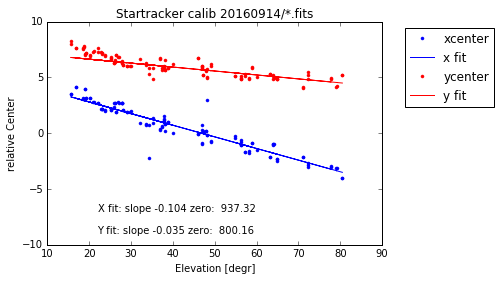

X fits: slope -0.104 zero: 937.32  rms  0.67
Y fits: slope -0.035 zero: 800.16  rms  0.42


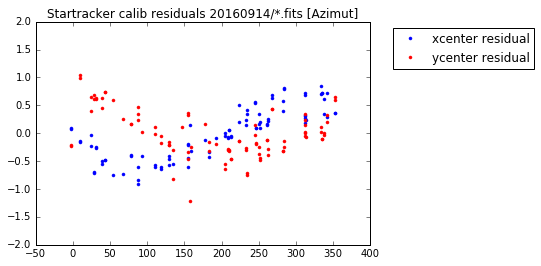

In [235]:
# and now analyze

elevcutoff = 25
sub_e = elevations[elevations > elevcutoff]
sub_xc = xCenters[elevations > elevcutoff]
sub_yc = yCenters[elevations > elevcutoff]


fitx = np.polyfit (sub_e, sub_xc,1)
fity = np.polyfit (sub_e, sub_yc,1)

fit_fx = np.poly1d(fitx)
fit_fy = np.poly1d(fity)

plt.plot (elevations, xCenters-3,  ".", label = "xcenter", color="blue")
plt.plot (elevations, fit_fx(elevations)-3, label = "x fit", color="blue")
plt.plot (elevations, yCenters, ".", label = "ycenter", color="red")
plt.plot (elevations, fit_fy(elevations),label = "y fit", color="red")
plt.xlabel ("Elevation [degr]")
plt.ylabel ("relative Center")
plt.xlim([10,90])
plt.ylim([-10,10])

fitx[1] += xref - starFitWindow
fity[1] += yref - starFitWindow

resX = (xCenters - fit_fx(elevations) + xref - starFitWindow)
resY = (yCenters - fit_fy(elevations) + yref - starFitWindow)

stdX = np.std (resX[elevations > elevcutoff])
stdY = np.std (resY[elevations > elevcutoff])



plt.text (22,-7, "X fit: slope % 6.3f zero: % 6.2f" % (fitx[0],fitx[1]))
plt.text (22,-9, "Y fit: slope % 6.3f zero: % 6.2f" % (fity[0],fity[1]))
lgd=plt.legend(loc=2, bbox_to_anchor=(1.05, 1.0),numpoints=1, ncol=1)
plt.title ("Startracker calib %s" % (inputDirectory))
plt.savefig ("startracker.pdf",bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()



plt.clf()



plt.plot (azimuts[elevations > elevcutoff], resX[elevations > elevcutoff],  ".", label = "xcenter residual", color="blue")
plt.plot (azimuts[elevations > elevcutoff], resY[elevations > elevcutoff], ".", label = "ycenter residual", color="red")

plt.ylim([-2,2])

lgd=plt.legend(loc=2, bbox_to_anchor=(1.05, 1.0),numpoints=1, ncol=1)
plt.title ("Startracker calib residuals %s [Azimut]" % (inputDirectory))
plt.savefig ("startrackerAZ.pdf",bbox_extra_artists=(lgd,), bbox_inches='tight')


print "X fits: slope %6.3f zero: %6.2f  rms % 5.2f" % (fitx[0],fitx[1],stdX)
print "Y fits: slope %6.3f zero: %6.2f  rms % 5.2f" % (fity[0],fity[1], stdY)
